In [48]:
import numpy as np
import matplotlib.pyplot as mp

data = np.genfromtxt('UnicornRecorder_baseline.csv', delimiter=',')
data = np.delete(data, 0, axis=0)

eegStartIndex = 0
numberOfEegChannels = 8
samplingRate = 250

eeg = data[:, eegStartIndex:numberOfEegChannels].copy()
samples = eeg.shape[0]
t = np.linspace(0, samples/samplingRate, num=samples)

#Timeseries

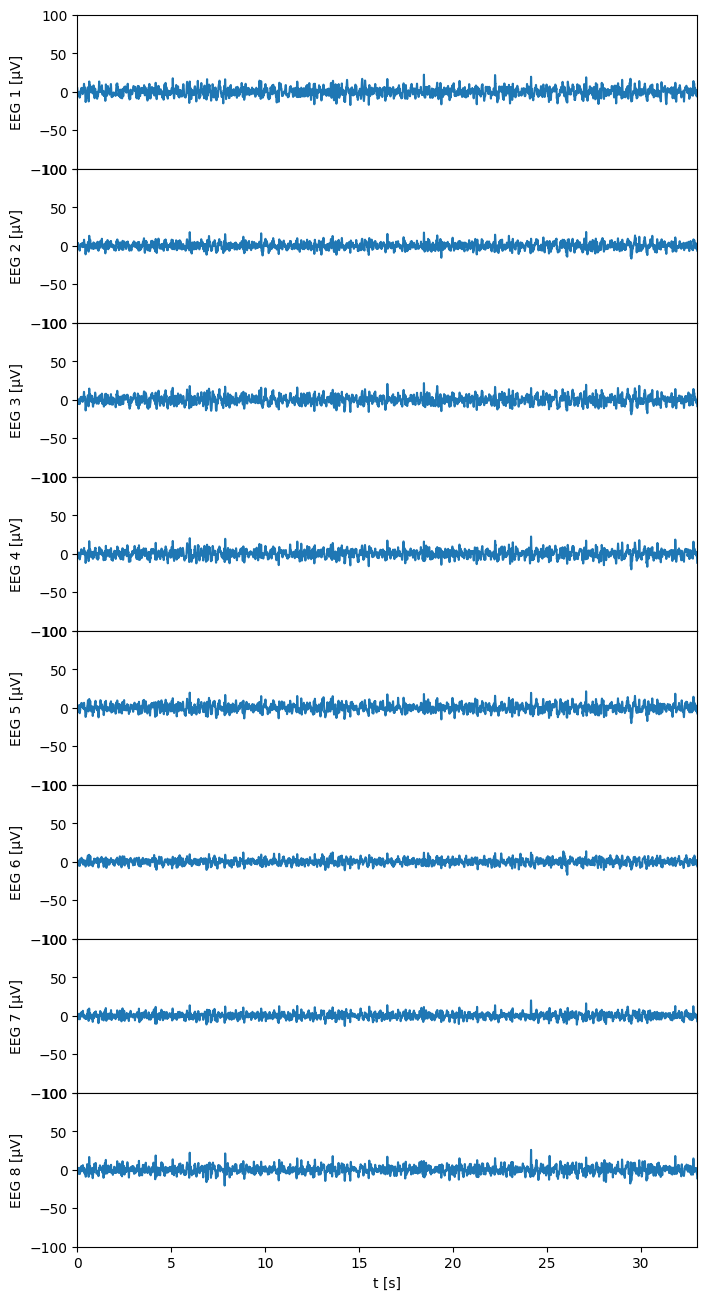

In [49]:
fig, axs = mp.subplots(numberOfEegChannels, 1, sharex=True, figsize=(8, 2*numberOfEegChannels), )
fig.subplots_adjust(hspace=0)
for i in range(numberOfEegChannels):
    axs[i].plot(t, eeg[:, i])
    axs[i].set_ylabel(f'EEG {i+1} [µV]')
    axs[i].set_ylim(-100, 100)
    axs[i].set_xlim(0, t[t.shape[0]-1])

axs[numberOfEegChannels - 1].set_xlabel('t [s]')
mp.show()